<a href="https://colab.research.google.com/github/michaelkinnas/HUA-Decision-Making-Systems-Semester-Project/blob/main/D_M_S__Semester_Project_team_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Εργασία στα Συστήματα Λήψης Αποφάσεων

Ομάδες 3 ατόμων deadline: 18/6/2023 

Στην παρούσα εργασία θα διαχειριστούμε και θα αναλύσουμε open και synthetic data για να εξάγουμε συμπεράσματα, να κάνουμε συστάσεις και να πάρουμε αποφάσεις για την επιλογή μουσικών συγκροτημάτων, καθώς και την αγορά/πώληση δίσκων. Για την εξαγωγή των opendata θα χρησιμοποιήσουμε το [Last.fm](https://www.last.fm/api) Music Discovery API [1] και/ή το [discogs API](https://www.discogs.com/developers) [2]

[1] https://www.last.fm/api

[2] https://www.discogs.com/developers


In [ ]:
import networkx as nx
from datetime import datetime
import numpy as np
import pandas as pd
import math
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Έστω ότι έχετε 20 users που σχηματίζουν ένα community όπως δίνεται από ένα Barabasi Albert model [3]. 

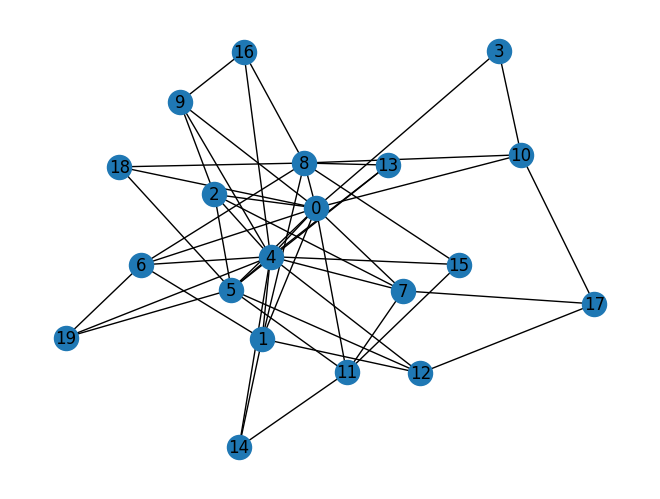

In [ ]:
community_graph= nx.barabasi_albert_graph(20,3)
nx.draw(community_graph, with_labels=True)


(α.) Σχεδιάστε το data model που θα αναπαριστά τους users του community, τα συγκροτήματα που τους αρέσουν καθώς και τους δίσκους που έχουν. Υλοποιήστε το scheme του data model σε μια σχεσιακή (SQL like) βάση δεδομένων (ΒΔ) και φτιάξτε συναρτήσεις που εισάγουν τυχαία δεδομένα της επιλογής σας για τους users. [Διάλεξη 3 MySQL]

Install mysql database

In [ ]:
!apt-get install mysql-server > /dev/null

Start mysql db

In [ ]:
!service mysql start
!mysql -e "ALTER USER 'root'@'localhost' IDENTIFIED WITH mysql_native_password BY 'root'"

 * Starting MySQL database server mysqld
su: warning: cannot change directory to /nonexistent: No such file or directory
   ...done.


Install python package

In [ ]:
!pip install mysql-connector-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 25.2 MB/s eta 0:00:00


Important Imports

In [ ]:
import mysql.connector
from mysql.connector import errorcode

Create database

In [ ]:
cnx = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="root"
)

cursor = cnx.cursor()

DB_NAME = 'music'

try: 
  cursor.execute(f"CREATE DATABASE {DB_NAME} DEFAULT CHARACTER SET 'utf8'")
except mysql.connector.Error as err: 
  print(err)
 # exit(1)
 
cursor.close()
cnx.close()

Create tables

In [ ]:
cnx = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="root",
    database="music"
)

cursor = cnx.cursor()

TABLES = {}
TABLES['users'] = '''
CREATE TABLE users (
	id int AUTO_INCREMENT,
	username varchar(255),
	PRIMARY KEY(id)
);
'''

TABLES['artists'] = '''
CREATE TABLE artists (
	id int AUTO_INCREMENT,
	name varchar(255),
	genre varchar(255),
	PRIMARY KEY(id)
);
'''

TABLES['albums'] = '''
CREATE TABLE albums (
	id int AUTO_INCREMENT,
	name varchar(255),
	release_year DATE,
	artist_id int,
	PRIMARY KEY(id),
	CONSTRAINT fk_albums_artists FOREIGN KEY (artist_id) REFERENCES artists(id) ON DELETE CASCADE  
);
'''

TABLES['price_history'] = '''
CREATE TABLE price_history (
	album_id int,
	price int,
	date_of_price DATE,
	CONSTRAINT fk_price_history_albums FOREIGN KEY (album_id) REFERENCES albums(id) ON DELETE CASCADE
);
'''

#**
TABLES['favourite_artists'] = '''
CREATE TABLE favourite_artists (
	user_id int,
	artist_id int,
	CONSTRAINT unique_favourite_artists UNIQUE (user_id , artist_id),
	CONSTRAINT fk_favourite_artists_users FOREIGN KEY (user_id) REFERENCES users(id) ON DELETE CASCADE,
	CONSTRAINT fk_favourite_artists_artists FOREIGN KEY (artist_id) REFERENCES artists(id) ON DELETE CASCADE
);
'''

TABLES['album_interests'] = '''
CREATE TABLE album_interests (
	user_id int,
	album_id int,
	CONSTRAINT unique_album_interests UNIQUE (user_id , album_id),
	CONSTRAINT fk_album_interests_users FOREIGN KEY (user_id) REFERENCES users(id) ON DELETE CASCADE,
	CONSTRAINT fk_album_interests_albums FOREIGN KEY (album_id) REFERENCES albums(id) ON DELETE CASCADE
);
'''

TABLES['album_owners'] = '''
CREATE TABLE album_owners (
	user_id int,
	album_id int,
	CONSTRAINT unique_album_owners UNIQUE (user_id , album_id),
	CONSTRAINT fk_album_owners_users FOREIGN KEY (user_id) REFERENCES users(id) ON DELETE CASCADE,
	CONSTRAINT fk_album_owners_albums FOREIGN KEY (album_id) REFERENCES albums(id) ON DELETE CASCADE
);
'''

TABLES['friends'] = '''
CREATE TABLE friends (
	user_id int,
	friend_id int,
	CONSTRAINT unique_friends UNIQUE (user_id , friend_id),
	CONSTRAINT fk_friends_users FOREIGN KEY (user_id) REFERENCES users(id) ON DELETE CASCADE,
	CONSTRAINT fk_friends_users_friend FOREIGN KEY (friend_id) REFERENCES users(id) ON DELETE CASCADE
);
'''


for key in TABLES:
  try:
    print(f'Creating table {TABLES[key]}: ')
    cursor.execute(TABLES[key])
  except mysql.connector.Error as err:
    print(err)
    # exit(1)

cursor.close()
cnx.close()

(β.) Για τον κάθε user του community φτιαξτε συναρτήσεις που να ανακτούν δεδομένα από τα opendata σε σχέση με τα συγκροτήματα που ακούει και τους δίσκους που τον ενδιαφέρουν και να γεμίζουν τα αντίστοιχα tables στην ΒΔ. [Rest calls στα [1] [2] και Διάλεξη 3 MySQL]  

Σημείωση: Για την επιλογή των attributes λάβετε υπόψη σας τα επόμενα ερωτήματα. Είναι φυσικό καθώς εξοικειώνεστε με την εργασία να αλλάζετε το σχήμα της ΒΔ και τα attributes). 

[1] https://www.last.fm/api

[2] https://www.discogs.com/developers

In [ ]:
#last.fm

import requests
import json
import time

BASE_URL ='https://ws.audioscrobbler.com'
API_KEY = 'dcd11816eb4ea6a7e2f20e4cffb34bd5'

def artist_info(artist_name: str):
  """Retrieve information about an artist from the last.fm API.

  :param artist_name: The name of the artist, required.
  :return: A JSON formatted string.  
  """
  time.sleep(0.1)
  response = requests.get(f'{BASE_URL}/2.0/?method=artist.getinfo&artist={artist_name}&api_key={API_KEY}&format=json')
  formatted = json.dumps(json.loads(response.content), indent=2)
  return formatted

def album_info(artist_name: str, album_name: str):
  """Retrieve information about an album from the last.fm API.

  :param artist_name: The name of the artist, required.
  :param album_name: The name of the album, required.
  :return: A JSON formatted string.  
  """
  time.sleep(0.1)
  response = requests.get(f'{BASE_URL}/2.0/?method=album.getinfo&api_key={API_KEY}&artist={artist_name}&album={album_name}&format=json')
  formatted = json.dumps(json.loads(response.content), indent=2)
  return formatted

def album_search(album_name: str):
  """Search for an album by name from the last.fm API. 
  Returns album matches sorted by relevance.

  :param album_name: The name of the album, required.
  :return: A JSON formatted string.
  """
  time.sleep(0.1)
  response = requests.get(f'{BASE_URL}/2.0/?method=album.search&album={album_name}&api_key={API_KEY}&format=json')
  formatted = json.dumps(json.loads(response.content), indent=2)
  return formatted

## Insert data functions

In [ ]:
# DB Inserts

#TODO check for valid JSON fields data
#TODO batch insert albums and artists

def insert_user(cursor, username):

    query = "INSERT INTO users (username) VALUES (%s)"
    try:
        cursor.execute(query, [username])
    except mysql.connector.Error as err:
        print(err)

def insert_artist(cursor, artist_name):

    query = "INSERT INTO artists (name, genre) VALUES (%s, %s)"
    artist_json = json.loads(artist_info(artist_name))
    artist_genre = artist_json['artist']['tags']['tag'][0]['name']
    values = (artist_name, artist_genre)
    try:
        cursor.execute(query, values)
        print(f'{artist_name} got inserted in the table!')
    except mysql.connector.Error as err:
        print(err)

def insert_album(cursor, album_name, artist_name):

    album_json = json.loads(album_info(artist_name, album_name))
    query = 'SELECT * FROM artists'
    cursor.execute(query)
    artist_id = None
    artist_no = 1
    for artist in cursor:
        if artist[1].__contains__(album_json['album']['artist']):
            artist_id = artist[0]
        artist_no = artist_no + 1
    if artist_id is None:
            insert_artist(cursor, artist_name)
            artist_id = artist_no
    release_year = "1999-01-01" # album_json['album']['releasedate']

    query = "INSERT INTO albums (name, release_year, artist_id) VALUES (%s, %s, %s)"
    values = (album_name, release_year, artist_id)
    try:
        cursor.execute(query, values)
    except mysql.connector.Error as err:
        print(err)



# def insert_price_history(cursor, album_id, price, date_of_price):

#     query = "INSERT INTO price_history (album_id, price, date_of_price) VALUES (%s, %s, %s)"
#     values = (album_id, price, date_of_price)
#     try:
#         cursor.execute(query, values)
#     except mysql.connector.Error as err:
#         print(err)

def insert_favourite_artists(cursor, user_id, artist_id):

    query = "INSERT INTO favourite_artists (user_id, artist_id) VALUES (%s, %s)"
    values = (user_id, artist_id)
    try:
        cursor.execute(query, values)
    except mysql.connector.Error as err:
        print(err)

def insert_album_interests(cursor, user_id, album_id):

    query = "INSERT INTO album_interests (user_id, album_id) VALUES (%s, %s)"
    values = (user_id, album_id)
    try:
        cursor.execute(query, values)
    except mysql.connector.Error as err:
        print(err)

def insert_album_owners(cursor, user_id, album_id):

    query = "INSERT INTO album_owners (user_id, album_id) VALUES (%s, %s)"
    values = (user_id, album_id)
    try:
        cursor.execute(query, values)
    except mysql.connector.Error as err:
        print(err)

def insert_friend(cursor, user_id, friend_id):

    query = "INSERT INTO friends (user_id, friend_id) VALUES (%s, %s)"
    values = (user_id, friend_id)
    try:
        cursor.execute(query, values)
    except mysql.connector.Error as err:
        print(err)

In [ ]:
# Create random users with random data 
import csv
import random

names = []
albums = []
artists = []

random_users = []

with open('gdrive/My Drive/HUA/6th Semester/Decision Making Systems/Project/new-top-firstNames.csv') as names_csv:
    csv_reader = csv.reader(names_csv, delimiter=',')
    headers = next(csv_reader) 
    for row in csv_reader:
        names.append(row[1])


with open('gdrive/My Drive/HUA/6th Semester/Decision Making Systems/Project/albumlist.csv', encoding = "ISO-8859-1") as albums_csv:
    csv_reader = csv.reader(albums_csv, delimiter=',')
    headers = next(csv_reader) 
    for row in csv_reader:
        albums.append(row[2])
        artists.append(row[3])


for i in range(20): #for each user
    name = names[random.randint(0, len(names)-1)]

    favorite_artists = []
    for i in range(random.randint(0, 6)):
        favorite_artists.append(artists[random.randint(0, len(artists)-1)])

    owned_albums = []
    for i in range(random.randint(0, 30)):
    #{"album":"Blackwater Park","artist":"Opeth"}
        rand_idx = random.randint(0, len(albums)-1)
        owned_albums.append({"album":albums[rand_idx], "artist":artists[rand_idx]})

    album_interests = []
    for i in range(random.randint(0, 4)):
        rand_idx = random.randint(0, len(albums)-1)
        album_interests.append({"album":albums[rand_idx], "artist":artists[rand_idx]})


    random_users.append({
        "username":name,
        "favorite_artists":favorite_artists,
        "owned_albums":owned_albums,
        "friends":[],
        "album_interests":album_interests
    })


User object represenation
```
  {
    "username":"Michael",
    "favorite_artists":["Opeth", "Cannibal Corpse", "Metallica", "Rotting Christ"],
    "owned_albums":[{"album":"Master of Puppets", "artist": "Metallica"}],
    "friends":[],
    "album_interests":[{"album":"Blackwater Park","artist":"Opeth"}]
  },
```



In [ ]:
#TODO Inserts for each user
# config = {
#     'host':'localhost',
#     'user':'root',
#     'passwd':'root',
#     'database':'music'
# }

# cnx = mysql.connector.connect(**config)
# cursor = cnx.cursor()

# cnx.commit()
# cursor.close()
# cnx.close()





# #secondary tables
# for user in random_users:
#     for artist in user['favorite_artists']:

# query = 'INSER INTO albums VALUES ()'

# for album in array:
#     query += f'({album["album"]}),'

# query = query[:-1]


# query


# print(album_info('Superfly ', 'Curtis Mayfield'))

(γ.) Υλοποιήστε μια συνάρτηση που να κάνει έλεγχο και να αντιμετωπίζει [missing](https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b) [4], [duplicate](https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python) [5] ή [outlier](https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623) [6] values σε κάποιο από τα attributes της ΒΔ. 

[4] https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b

[5] https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python

[6] https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623

(δ.) Βγάλτε κάποια στατιστικά συμπεράσματα για τα data features [7] [8]

[7] https://pandas.pydata.org/docs/getting_started/intro_tutorials/06_calculate_statistics.html

[8] https://sparkbyexamples.com/pandas/calculate-summary-statistics-in-pandas/

(ε.) Αναπαραστήστε γραφικά κάποια attributes των δεδομένων σας και εξηγήστε τα συμπεράσματα που εξάγετε [διάλεξη data visualization].

(στ.) Έστω το synthetic time series dataset στο επόμενο κελί που έχει την χαμηλότερη τιμή που πωλείται ένας δίσκος κάθε μέρα, αναπαραστήστε την χρονοσειρά και το decompose της σε trend, seasonality και residuals [διάλεξη και lab time series].

<Axes: >

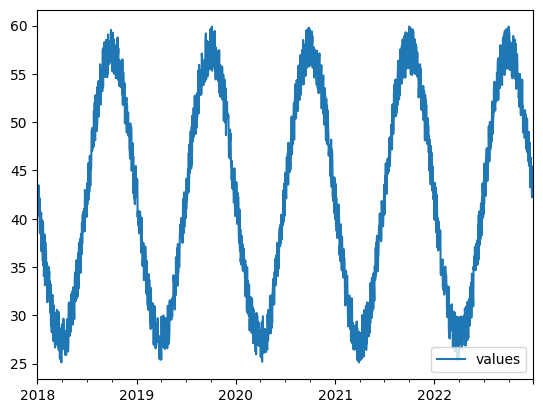

In [ ]:
date_rng = pd.date_range(start='1/1/2018', end='12/31/2022', freq='D')
val=40+15*np.tile(np.sin(np.linspace(-np.pi, np.pi, 365)),5)
val=np.append(val,val[1824])+5*np.random.rand(1826)
series = pd.DataFrame({
    'values': val
}, index=pd.DatetimeIndex(date_rng))
series.plot()
#series.to_csv('gdrive/My Drive/File_series.csv', index=True, header=True)

(ζ.) Χωρίστε τα data της χρονοσειράς σε 76% training και 34% testing, εκπαιδεύστε ένα ARIMA μοντέλο στο training split το οποίο να προβλέπει την χαμηλότερη τιμή που θα πωλείται ένας δίσκος την επόμενη ημέρα  και αξιολογήστε την απόδοση του στο testing split [διάλεξη και lab time series].

(η.) Με χρήση κάποιας graph mining μετρικής πάνω στον γράφο του community να προτείνετε σε κάποιον user έναν δίσκο που δεν έχει επιλέξει [διάλεξη graph mining]. 

(θ.) Έστω μια σειρά από users (user_money_rates) που διαθέτουν κάποια χρηματικά ποσά και έχουν εκδηλώσει την βαθμονομημένη επιθυμία τους να αγοράσουν μια σειρά από δίσκους. Η επιθυμία εκδηλώνεται με έναν βαθμό απο 1 εως 5 για κάθε δίσκο και κάθε δίσκος έχει ένα χρηματικό κόστος (album_price). Χρησιμοποιήστε έναν γενετικό αλγόριθμο για να επιλέξει τους δίσκους που θα προτείνει στους users να αγοράσουν με σκοπό να μεγιστοποιήσουν τον συνολικό βαθμό επιθυμίας των δίσκων, δεδομένου του διαθέσιμου χρηματικού ποσού που διαθέτει ο κάθε user. Συγκρίνετε τα αποτελέσματα με μια τυχαία επιλογή δίσκων. [διάλεξη genetic algorithms].

In [ ]:
users_money = 200 + np.ceil(100*np.random.rand(100))
user_money_rates=np.empty_like(np.append(users_money[0],np.random.randint(5, size=50)+1))
for i in users_money:
  user_money_rates=np.vstack([user_money_rates,np.append(i,np.random.randint(5, size=50)+1)])
user_money_rates=np.delete(user_money_rates,(0),axis=0)

album_price=np.random.randint(50, size=100)+1
#np.savetxt("gdrive/My Drive/user_money_rates.csv", user_money_rates, delimiter=",")
#np.savetxt("gdrive/My Drive/album_price.csv", album_price, delimiter=",")